In [1]:
import os
import datetime

import numpy as np
import pandas as pd

from pyproj import Transformer
import geopandas as gpd
from shapely.geometry import Point
import movingpandas as mpd

import matplotlib.pyplot as plt
import matplotlib as mlp
import scienceplots
plt.style.use("science")
import seaborn as sns

import folium as fl
from folium.plugins import FastMarkerCluster

from IPython.core.display_functions import clear_output

# Load Data

In [2]:
df = pd.read_csv("./data/1_france_data.csv")

In [3]:
df.head()

,BaseDateTime,LAT,LON,SOG,COG,Status,vessel
0,2015-12-16 09:31:35,48.381700,-4.471865,0.0,28.9,5.0,207138000
1,2015-12-16 09:31:45,48.381706,-4.471863,0.0,33.6,5.0,207138000
2,2015-12-16 09:31:54,48.381680,-4.471873,0.0,24.7,5.0,207138000
3,2015-12-16 09:32:05,48.381653,-4.471885,0.0,30.0,5.0,207138000
4,2015-12-16 09:32:15,48.381668,-4.471892,0.0,24.5,5.0,207138000


# Navigational Status Inconsistency

In [4]:
ais_inconsistent_status = df.loc[(df["Status"] == 5) & (df["SOG"] >= 1), ["LAT", "LON", "SOG"]]
ais_inconsistent_status_points = gpd.points_from_xy(ais_inconsistent_status["LON"],
                                                    ais_inconsistent_status["LAT"],
                                                    crs=4326)
gdf_ais_inconsistent_status = gpd.GeoDataFrame(ais_inconsistent_status,
                                               geometry=ais_inconsistent_status_points)

In [5]:
import geopandas as gpd
print(gpd.__version__)


0.13.0


C:\Users\rendr\AppData\Local\Temp\ipykernel_17424\3611515887.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


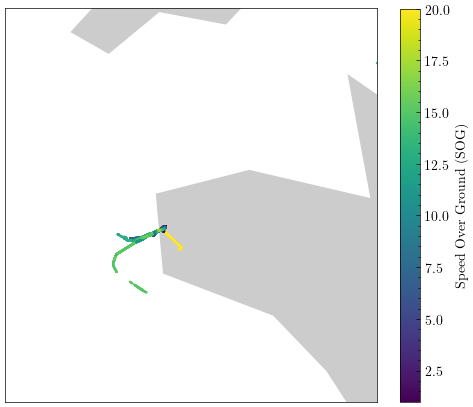

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.plot(ax=ax, alpha=0.4, color="grey")

legend_kwds = {
    "orientation": "vertical",
    "shrink": 0.85,
    "label": "Speed Over Ground (SOG)"
}
gdf_ais_inconsistent_status.plot(column="SOG", markersize=0.5, ax=ax,
                                 legend=True, legend_kwds=legend_kwds)
plt.xlim([gdf_ais_inconsistent_status["LON"].min() - 1.5,
          gdf_ais_inconsistent_status["LON"].max() + 0])
plt.ylim([gdf_ais_inconsistent_status["LAT"].min() - 1,
          gdf_ais_inconsistent_status["LAT"].max() + 0.5])
plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])

plt.savefig("./figures/nav_status_inconsistency_france")
plt.show()

# Split Voyages

In [7]:
ports = gpd.read_file("./data/france_data/Ports_Brittany/port.shp")
brest_port = ports[ports["libelle_po"] == "Brest"]
lon = brest_port.iloc[0]["geometry"].geoms[0].xy[0][0]
lat = brest_port.iloc[0]["geometry"].geoms[0].xy[1][0]

In [8]:
print(f"({lon}, {lat})")

(-4.475309812300752, 48.38273389573341)


In [9]:
berth_port_coords = [lat, lon-0.01]

In [10]:
df_clean = df.copy()

In [11]:
transformer = Transformer.from_crs(4326, 3857)
x, y = transformer.transform(df_clean["LAT"].to_numpy(), df_clean["LON"].to_numpy())

In [12]:
df_clean["x"] = x
df_clean["y"] = y

In [13]:
# Get the distance of each point to the port (defined by the quay point)
quay_point = Point(transformer.transform(berth_port_coords[0], berth_port_coords[1]))
distanceToPort = gpd.points_from_xy(df_clean.x, df_clean.y, crs=3857).distance(quay_point)
df_clean["distanceToPort"] = distanceToPort

In [14]:
# Get arrival point (first point within 4km of the quay center with
# Status = 5 and SOG < 1 knot)
df_clean["arrival_point"] = 0
df_clean.loc[(df_clean["distanceToPort"] < 3500)
             & (df_clean["Status"] == 5)
             & (df_clean["SOG"] < 1), "arrival_point"] = 1
points_after_arrival = (df_clean["arrival_point"].diff() != 1) \
                       & (df_clean["arrival_point"] == 1)
df_clean = df_clean.loc[~points_after_arrival, :]
df_clean.reset_index(drop=True, inplace=True)

In [15]:
# Enumerate voyages (where arrival_point = 1 subtract 1)
df_clean["voyage"] = df_clean.groupby("vessel")["arrival_point"].cumsum().values
df_clean.loc[df_clean["arrival_point"] == 1, "voyage"] -= 1

In [16]:
# map vessel ids to smaller numbers
vessel_id_map = pd.Series(data=np.arange(1, df_clean["vessel"].unique().shape[0]+1),
                          index=df_clean["vessel"].unique()).to_dict()

df_clean["vessel"] = df_clean["vessel"].map(vessel_id_map)

# Build vessel-voyage pairs (voyage ids)
df_clean["voyage_id"] = df_clean["vessel"].astype(str) + "-" \
                        + df_clean["voyage"].astype(str)

In [17]:
df_clean["BaseDateTime"] = pd.to_datetime(df_clean["BaseDateTime"])

In [18]:
# Get the remaining time from each msg to the arrival message (remaining voyage time)
remainingVoyageTime = df_clean.groupby("voyage_id") \
    .apply(lambda x: x.iloc[-1]["BaseDateTime"] - x.loc[:, "BaseDateTime"]) \
    .sort_index(level=1)
df_clean["remainingVoyageTime"] = (remainingVoyageTime.dt.total_seconds() / 60).values

C:\Users\rendr\AppData\Local\Temp\ipykernel_17424\340126289.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.iloc[-1]["BaseDateTime"] - x.loc[:, "BaseDateTime"]) \


In [19]:
# Take only msgs within 2 days of a vessel's arrival
df_clean = df_clean.loc[df_clean["remainingVoyageTime"] <= 48*60]

In [20]:
# Take only points at least 10 Km from the terminal location
df_clean = df_clean.loc[df_clean["distanceToPort"] >= 10000]

In [21]:
# Convert distance in meters to nautical miles
df_clean["distanceToPort"] *= 0.000539956803

In [22]:
m = fl.Map(location=berth_port_coords, zoom_start=8)

moored_points = df_clean.loc[(df_clean["Status"] == 5)
                             & (df_clean["SOG"] < 1.0), ["LAT", "LON"]]

fmc = FastMarkerCluster(data=moored_points.values)
fmc.add_to(m)

m

In [23]:
m = fl.Map(location=berth_port_coords, zoom_start=8)

anchored_points = df_clean.loc[(df_clean["Status"] == 1)
                               & (df_clean["SOG"] < 5.0), ["LAT", "LON"]]

fmc = FastMarkerCluster(data=anchored_points.values)
fmc.add_to(m)

m

In [24]:
# Remove messages until vessels leave the last port

# Moored points
df_clean = df_clean.groupby("voyage_id") \
    .apply(lambda x: x if x.loc[(x["Status"] == 5)
                                & (x["SOG"] < 1), "BaseDateTime"].max() is pd.NaT
                        else x[x["BaseDateTime"]
                               > (x.loc[(x["Status"] == 5)
                                        & (x["SOG"] < 1), "BaseDateTime"].max())]) \
                            .sort_index(level=1).reset_index(drop=True)

# Anchored points
df_clean = df_clean.groupby("voyage_id") \
    .apply(lambda x: x if x.loc[(x["Status"] == 1)
                                & (x["SOG"] < 5), "BaseDateTime"].max() is pd.NaT
                        else x[x["BaseDateTime"]
                            > (x.loc[(x["Status"] == 1)
                                        & (x["SOG"] < 5), "BaseDateTime"].max())]) \
                            .sort_index(level=1).reset_index(drop=True)

C:\Users\rendr\AppData\Local\Temp\ipykernel_17424\3146608109.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x if x.loc[(x["Status"] == 5)
C:\Users\rendr\AppData\Local\Temp\ipykernel_17424\3146608109.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x if x.loc[(x["Status"] == 1)


In [25]:
# Remove voyages with less than 100 msgs
invalid_voyages = df_clean["voyage_id"].value_counts() < 100
invalid_voyages = invalid_voyages[invalid_voyages].index.values
df_clean = df_clean.loc[~df_clean["voyage_id"].isin(invalid_voyages)]

In [26]:
df_clean["voyage_id"].value_counts().min()

148

In [27]:
df_clean["voyage_id"].unique().shape

(164,)

In [28]:
df_clean["vessel"].unique().shape

(66,)

# Visualize voyages

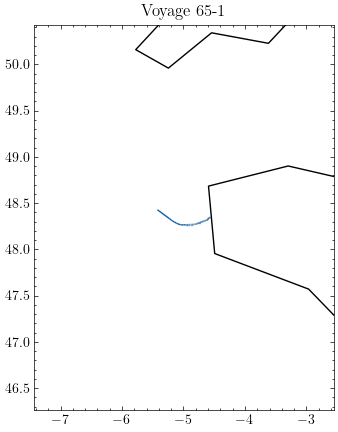

In [29]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"), crs="EPSG:4326")
europe = world.query("continent == 'Europe'")

for voyage_id, voyage_data in df_clean.groupby("voyage_id"):

    trajectory = mpd.Trajectory(df=voyage_data,
                                traj_id=voyage_id,
                                t="BaseDateTime",
                                x="LON", y="LAT")

    fig, ax = plt.subplots(figsize=(5, 5))
    europe.plot(ax=ax, color="white", edgecolor="black")
    trajectory.plot(ax=ax)

    ax.set_xlim([voyage_data["LON"].min() - 2, voyage_data["LON"].max() + 2])
    ax.set_ylim([voyage_data["LAT"].min() - 2, voyage_data["LAT"].max() + 2])
    ax.set_title(f"Voyage {voyage_id}")
    plt.show()

    clear_output(wait=True)
    plt.pause(1)

In [ ]:
voyages_to_remove = ["3-0", "19-1"]

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"), crs="EPSG:4326")
europe = world.query("continent == 'Europe'")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

for i in range(0, 2):

    voyage_data = df_clean.loc[df_clean["voyage_id"] == voyages_to_remove[i],
                               ["voyage_id", "BaseDateTime", "LON", "LAT"]]
    
    trajectory = mpd.Trajectory(df=voyage_data,
                                traj_id="voyage_id",
                                t="BaseDateTime",
                                x="LON", y="LAT")

    europe.plot(ax=axs[i%2], color="white", edgecolor="black")
    trajectory.plot(ax=axs[i%2])
    axs[i%2].set_xlim([voyage_data["LON"].min() - 2, voyage_data["LON"].max() + 2])
    axs[i%2].set_ylim([voyage_data["LAT"].min() - 2, voyage_data["LAT"].max() + 2])
    axs[i%2].set_title(f"Voyage {voyage_data['voyage_id'].values[0]}")
    axs[i%2].set_ylabel("Latitude")
    axs[i%2].set_xlabel("Longitude")

plt.savefig("./figures/app_rem_voyages_brest")
plt.show()

In [ ]:
voyages_to_remove = ["3-0", "19-1"]

trajectories = mpd.TrajectoryCollection(data=df_clean[df_clean["voyage_id"].isin(voyages_to_remove)], 
                                        traj_id_col="voyage_id", t="BaseDateTime", x="LON", y="LAT", crs="epsg:4326")
    
m = fl.Map(width=500, height=500, location=berth_port_coords, zoom_start=8)

i = 0
for trajectory in trajectories.trajectories:
    coords = [[x[1], x[0]] for x in trajectory.to_linestring().coords]
    fl.PolyLine(coords, weight=2, opacity=1, popup=trajectory.id).add_to(m)
    i+=1
    
m

In [ ]:
voyages_to_remove = ["3-0", "19-1"]

df_clean = df_clean[~df_clean["voyage_id"].isin(voyages_to_remove)]

In [ ]:
df_clean["voyage_id"].unique().shape

In [ ]:
df_clean["vessel"].unique().shape

Modificado

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load world data and filter for Europe
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"), crs="EPSG:4326")
europe = world.query("continent == 'Europe'")

# Prepare colormap
cmap = plt.get_cmap("winter")

# Prepare plot
fig, ax = plt.subplots(figsize=(5,5))
europe.plot(ax=ax, color="white", edgecolor="black")

# Assuming df_clean and 'distanceToPort' are properly defined elsewhere in your script:
dist_norm = (df_clean["distanceToPort"] - df_clean["distanceToPort"].min()) \
            / (df_clean["distanceToPort"].max() - df_clean["distanceToPort"].min())

# Create a ScalarMappable for use with the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=df_clean["distanceToPort"].min(), vmax=df_clean["distanceToPort"].max()))
sm.set_array([])  # This can sometimes help with tricky colorbar issues

# Plot scatter with normalized colors
ax.scatter(df_clean["LON"], df_clean["LAT"], c=cmap(dist_norm), s=0.0001)

# Set plot limits
ax.set_xlim([df_clean["LON"].min() - 2, df_clean["LON"].max() + 2])
ax.set_ylim([df_clean["LAT"].min() - 2, df_clean["LAT"].max() + 2])

# Set labels
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")

# Create colorbar specifically referring to 'ax'
cbar = fig.colorbar(sm, ax=ax, shrink=0.85)
cbar.set_label("Distance to the Port (nautical miles)")

# Save and show plot
plt.savefig("./figures/final_brest_data")
plt.show()


In [ ]:
df_clean = df_clean[["vessel", "voyage", "voyage_id",
                     "BaseDateTime", "LON", "LAT", "SOG", "COG",
                     "distanceToPort", "remainingVoyageTime",
                     "x", "y"]]

In [ ]:
df_clean.head()

In [ ]:
df_clean.info()

In [ ]:
df_clean.to_csv("./data/2_france_voyages.csv", index=False)